# Objective

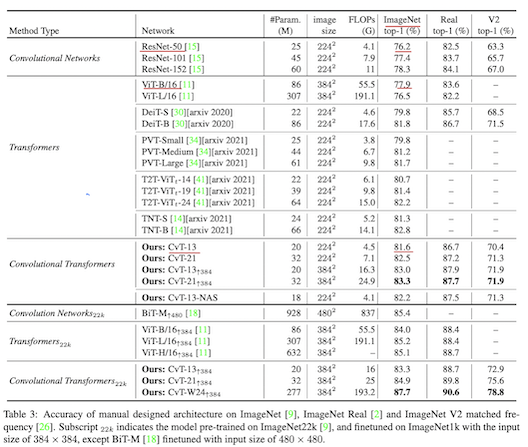

- Verify the performance of the CvT model by performing an accuracy measurement on the ImagNet-1k validation set
- ViT-B-16 Model is pre-trained on ImageNet

## All of these codes are not in the paper. To verify the paper's experiment, it is a code reproduced by referring to the content learned in this course and the codes in the references.

## Setup Environment

In [ ]:
!nvidia-smi

Sun May 22 09:17:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/FinalProject/ImageNetTask

/content/gdrive/MyDrive/FinalProject/ImageNetTask


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Load Data (ImageNet-1k Validation Set)
 - Parameters references
 - https://pytorch.org/vision/stable/models.html

In [ ]:
transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
         ])

- To run this cell, have to download 'ILSVRC2012_img_val.tar', 'ILSVRC2012_devkit_t12.tar'
- Need not unzip!!
- Download the two files and Copy on the "/content/gdrive/MyDrive/FinalProject/ImageNetTask"
- Download Link: https://image-net.org/challenges/LSVRC/2012/2012-downloads.php

- Unfortunately, we cannot download the ImageNet within the code...
  https://stackoverflow.com/questions/60607824/pytorch-imagenet-dataset

In [ ]:
Downloaded_path = "/content/gdrive/MyDrive/FinalProject/ImageNetTask"
# Using torchvision library, you can simply get the testset.
test_set = torchvision.datasets.ImageNet(root=Downloaded_path, 
                                         transform=transform, split='val') 
test_loader = data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
batch = next(iter(test_loader))

images, labels = batch

print(images.shape) # batch_size, channel, height and width
print(labels) 
print(len(test_set)) # number of images

torch.Size([4, 3, 224, 224])
tensor([0, 0, 0, 0])
50000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


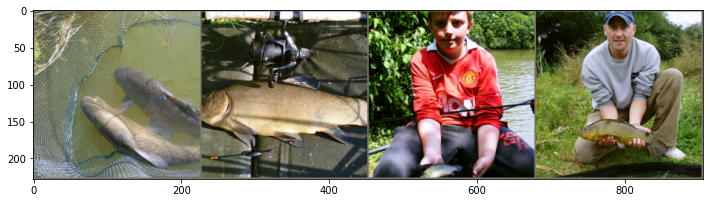

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Inverse the normalisation
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def imshow(img):
    img = inverse_normalize(tensor=img, mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.255])  
    npimg = img.numpy()
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))

## Load the pre-trained Model

In [ ]:
# ViT-B-16
# Pre-trained on ImageNet
import torchvision.models as models
model = models.vit_b_16(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

##Test the Model on ImageNet Validation Set

In [ ]:
# Formating Function
def nFormat(n):
    s = str(n)
    result = ""
    while True:
        if len(s) > 3:
            result = "," + s[-3:] + result
            s = s[:-3]
        else:
            result = s + result
            break
    return result

def tFormat(n):
    n = int(n)
    second = n%60
    minute = n//60
    return f'{minute}m {second}s'

In [ ]:
n_total_steps = len(test_set)
n_iterations = -(-n_total_steps // 4) # batch size = 4 
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

start = time.time()

with torch.no_grad():
    correct_top1 = 0
    correct_top5 = 0
    n_samples = 0
        
    model.eval()

    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)      # [4, 3, 224, 224]
        labels = labels.to(device)      # [4]
        outputs = model(images)

        # rank 1
        _, pred = torch.max(outputs, 1)
        n_samples += labels.size(0)
        correct_top1 += (pred == labels).sum().item()

        # rank 5
        _, rank5 = outputs.topk(5, 1, True, True)
        rank5 = rank5.t()
        correct5 = rank5.eq(labels.view(1, -1).expand_as(rank5))

        for k in range(6):
            correct_k = correct5[:k].reshape(-1).float().sum(0, keepdim=True)
        correct_top5 += correct_k.item()

        if (idx+1) % ((n_total_steps//4)//5) == 0:
            print("step : {} / {}".format(idx + 1, len(test_set)/int(labels.size(0))))
            print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / n_samples * 100))
            print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / n_samples * 100))
            
print("============Final Accuracy============")    
print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / n_samples * 100))
print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / n_samples * 100))

test_time = time.time() - start

Total steps: 50000
Iterations per epoch: 12500
step : 2500 / 12500.0
top-1 percentage :  86.11%
top-5 percentage :  97.10%
step : 5000 / 12500.0
top-1 percentage :  85.89%
top-5 percentage :  97.19%
step : 7500 / 12500.0
top-1 percentage :  83.17%
top-5 percentage :  96.13%
step : 10000 / 12500.0
top-1 percentage :  81.75%
top-5 percentage :  95.43%
step : 12500 / 12500.0
top-1 percentage :  81.07%
top-5 percentage :  95.32%
============Final Accuracy============
top-1 percentage :  81.07%
top-5 percentage :  95.32%


In [ ]:
print('number of parameter',nFormat(sum(p.numel() for p in model.parameters())))
print('test time',tFormat(test_time))

number of parameter 86,567,656
test time 11m 40s


# Result
###CvT-13
 - Top-1: 81.44%
 - Top-5: 95.67%
 - Test Time: 10m 13s
 - Parameters: 19,997,480

###ViT-B-16
 - Top-1: 81.07%
 - Top-5: 95.32%
 - Test Time: 11m 40s
 - Parameters: 86,567,656

###Resnet50_32x4d
 - Top-1: 77.62%
 - Top-5: 93.70%
 - Test Time: 8m 46s
 - Parameters: 25,028,904

## References
- https://pytorch.org/vision/stable/models.html
- https://arxiv.org/abs/2103.15808